In [ ]:
# import python modules
import random
import math
import copy
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook
%matplotlib inline
from ipywidgets import *
#from mpl_toolkits import mplot3d
import matplotlib as mpl

In [ ]:
# Initialize the system

# Set the number of atoms in the box
n_atoms = 25

# Set the number of Monte Carlo moves to perform
num_moves = 10000

# Set the size of the box (in Angstroms)
L = 15;
box_size = [ L, L]

# The maximum amount that the atom can be translated by
max_translate = 0.5    # angstroms


# ***NPT: The maximum amount to change the volume - the
# best value is 10% of the number of atoms
max_volume_change = 0.1 * n_atoms   # angstroms**3

#***NPT: Simulation pressure
pressure = 1           # atmospheres

#***NPT: Convert pressure to internal units (kcal mol-1 A-2)
pressure = pressure * 1.458397506863647E-005*L

# Simulation temperature
temperature = 10 # kelvin

# calculate kT
k_boltz = 1.987206504191549E-003  # kcal mol-1 K-1

kT = k_boltz * temperature

# Give the Lennard Jones parameters for the atoms
sigma = 2.41         # angstroms
epsilon = 4.63      # kcal mol-1

# colormap for coloring each atom by a different color
t = np.arange(n_atoms)

In [ ]:
# Create an array to hold the coordinates of the atoms
coords = []

# Randomly generate the coordinates of the atoms in the box
for i in range(0,n_atoms):
    # Note "random.uniform(x,y)" would generate a random number
    # between x and y
    coords.append( [random.uniform(0,box_size[0]), \
                    random.uniform(0,box_size[1])])
    
coords = np.array(coords)

In [ ]:
# calculates the energies of the system using Lennard Jones potential

# coords = 2 dimensional array
# coords[i][0] = ith atom, x-position
# coords[i][1] = ith atom, y-position
# coords[i][2] = ith atom, z-position
def calculate_energy(coords, n_atoms):
    total_energy = 0

    for i in range(0,n_atoms-1):
        for j in range(i+1, n_atoms):
            delta_x = coords[j][0] - coords[i][0]
            delta_y = coords[j][1] - coords[i][1]
            #delta_z = coords[j][2] - coords[i][2]

            # Apply periodic boundaries
            delta_x = make_periodic(delta_x, box_size[0])
            delta_y = make_periodic(delta_y, box_size[1])
            #delta_z = make_periodic(delta_z, box_size[2])

            # Calculate the distance between the atoms
            r = math.sqrt( (delta_x*delta_x) + (delta_y*delta_y)) 
            
            # E_LJ = 4*epsilon[ (sigma/r)^12 - (sigma/r)^6 ]
            e_lj = 4.0 * epsilon * ( (sigma/r)**12 - (sigma/r)**6 )

            total_energy += e_lj

    # return the total energy of the atoms
    return total_energy

In [ ]:
# Apply periodic boundary conditions

def make_periodic(x, box):
    """Subroutine to apply periodic boundaries"""
    while (x < -0.5*box):
        x += box

    while (x > 0.5*box):
        x -= box

    return x

In [ ]:
# Wrap the atom positions into the box

def wrap_into_box(x, box):
    """Subroutine to wrap the coordinates into a box"""
    while (x > box):
        x -= box

    while (x < 0):
        x += box

    return x

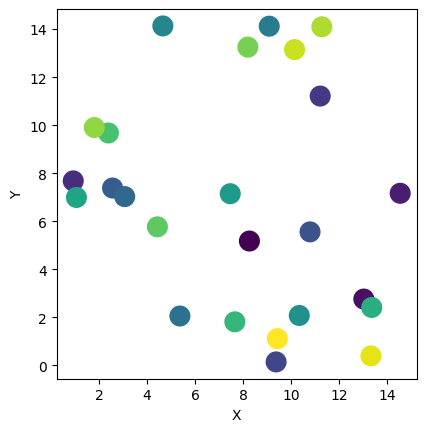

In [ ]:
# plot figure

def plot_figure(coords):
    
    fig = plt.figure()
    ax = fig.add_subplot()
    #ax = plt.axes(projection ="3d")
    plt.scatter(coords[:,0],coords[:,1],s=200,c=t)
    #line = ax.scatter3D(coords[:,0], coords[:,1],coords[:,2],color = "green")
    plt.xlabel('X')
    plt.ylabel('Y')
    #ax.set_zlabel('Z')
    # square plot
    ax.set_aspect('equal', adjustable='box')

    fig.canvas.draw()

plot_figure(coords)

In [ ]:
def write_xyz(coords,n_atoms,filename):
  with open(filename,'w') as xyzfile:
    xyzfile.write("%d\n\n" % n_atoms)
    for i in range(0,n_atoms):
      #xyzfile.write("{:4} {:11.6f} {:11.6f} {:11.6f}\n".format("Fe",coords[i,0],coords[i,1],coords[i,2]))
      xyzfile.write("{:4} {:11.6f} {:11.6f} {:11.6f}\n".format("Fe",coords[i,0],coords[i,1],0.0))
  

In [ ]:
def montecarlo(num_moves, box_size,n_atoms,coords, kT):
    
    # The total number of accepted move
    naccept = 0

    # The total number of rejected moves
    nreject = 0

    energy_all = []
    density_all=[]
    # ***NPT: The maximum amount to change the volume - the
    # best value is 10% of the number of atoms
    max_volume_change = 0.1 * n_atoms   # angstroms**3

    # Now perform all of the moves
    for move in range(1,num_moves+1):

        # calculate the old energy
        old_energy = calculate_energy(coords, n_atoms)

        # ***NPT: save the old box dimensions
        old_box_size = copy.deepcopy(box_size)

        # ***NPT: calculate the old volume of the box
        V_old = box_size[0] * box_size[1]

        # Pick a random atom (random.randint(x,y) picks a random
        # integer between x and y, including x and y)
        atom = random.randint(0, n_atoms-1)

        # save the old coordinates
        old_coords = copy.deepcopy(coords)

           #***NPT: Decide if we are performing an atom move, or a volume move
        if random.uniform(0.0,1.0) <= (1.0 / n_atoms):
            # 1 in n_atoms chance of being here. Perform a volume move
            # by changing the volume for a random amount
            delta_vol = random.uniform(-max_volume_change, max_volume_change)

            # calculate the new volume
            V_new = V_old + delta_vol

            # The new box length is the cube root of the volume
            box_side = V_new**(1.0/2.0)

            # The amount to scale each atom from the center is 
            # the cube root of the ratio of the new and old volumes
            scale_ratio = ( V_new / V_old )**(1.0/2.0)

            # now translate every atom so that it is scaled from the center 
            # of the box
            for i in range(0,n_atoms):
                dx = coords[i][0] - (0.5*box_size[0])
                dy = coords[i][1] - (0.5*box_size[1])
                #dz = coords[i][2] - (0.5*box_size[2])

                length = math.sqrt(dx*dx + dy*dy)

                if length > 0.01:   # don't scale atoms already near the center
                    dx /= length
                    dy /= length
                    #dz /= length

                    # now scale the distance from the atom to the box center 
                    # by 'scale_ratio'
                    length *= scale_ratio

                    # move the atom to its new location
                    coords[i][0] = (0.5*box_size[0]) + dx*length
                    coords[i][1] = (0.5*box_size[1]) + dy*length
                    #coords[i][2] = (0.5*box_size[2]) + dz*length

            box_size[0] = box_side
            box_size[1] = box_side
            #box_size[2] = box_side

        else:
            #*** same as in the NVT simulation
            # Make the move - translate by a delta in each dimension
            delta_x = random.uniform( -max_translate, max_translate )
            delta_y = random.uniform( -max_translate, max_translate )
            #delta_z = random.uniform( -max_translate, max_translate )

            coords[atom][0] += delta_x
            coords[atom][1] += delta_y
            #coords[atom][2] += delta_z

            # wrap the coordinates back into the box
            coords[atom][0] = wrap_into_box(coords[atom][0], box_size[0])
            coords[atom][1] = wrap_into_box(coords[atom][1], box_size[1])
            #coords[atom][2] = wrap_into_box(coords[atom][2], box_size[2])

        # calculate the new energy
        new_energy = calculate_energy(coords, n_atoms)

        # ***NPT: calculate the new volume of the box
        V_new = box_size[0] * box_size[1]

        accept = False

        # Apply Metropolis crierion
        # Automatically accept if the energy goes down 
        if (new_energy <= old_energy):
            accept = True
        # If energy goe

        else:
            # Now apply the Monte Carlo test - compare
            # exp( -(E_new - E_old) / kT ) >= rand(0,1)
            #x = math.exp( -(new_energy - old_energy) / kT )

            # ***NPT: Now apply the Monte Carlo test - compare
            # exp( -( \delta E - p \delta V ) / kT  +  N \delta ln V ) >= rand(0,1)
            # assume ideal gas for the entropy change
            TdS =  n_atoms * kT* math.log(V_new/V_old);
            dH = new_energy - old_energy + pressure * (V_new - V_old)
            dG = dH - TdS
            x = math.exp( -dG / kT )

            if (x >= random.uniform(0.0,1.0)):
                accept = True
            else:
                accept = False

        if accept:
            # accept the move
            naccept += 1
            total_energy = new_energy
        else:
            # reject the move - restore the old coordinates
            nreject += 1

            # restore the old conformation
            coords = copy.deepcopy(old_coords)

            #***NPT
            box_size = copy.deepcopy(old_box_size)

            total_energy = old_energy
         
        density = n_atoms/(box_size[0]*box_size[1])
        energy_all.append(total_energy)
        density_all.append(density)
        # print the energy every 10 moves
        '''
        if move % 10 == 0:
            print("%s %s  %s  %s" % (move, total_energy, naccept, nreject))
            print("Box size = %sx%sx. Volume = %s A^2" % \
                     (box_size[0], box_size[1], box_size[0]*box_size[1]))
        '''
    return energy_all, density_all, coords

In [ ]:
num_moves = 1000
Ntrial = 1
T_all = [10, 300, 3000]
final_energy = np.zeros((len(T_all),Ntrial))
final_density = np.zeros((len(T_all),Ntrial))

for t in range(0,len(T_all)):
    temp = T_all[t]
    kT = k_boltz*temp
    for i in range(0,Ntrial):
        print("Temp", temp, "trial",i)
        energy_all, density_all, coords=montecarlo(num_moves, box_size,n_atoms,coords, kT)
        final_energy[t,i]=energy_all[-1]
        final_density[t,i]=density_all[-1]
print(final_energy)
print(final_density)

Temp 10 trial 0
Temp 300 trial 0
Temp 3000 trial 0
[[-246.42098393]
 [-257.06227323]
 [-208.08263795]]
[[0.11121275]
 [0.10965527]
 [0.11159804]]


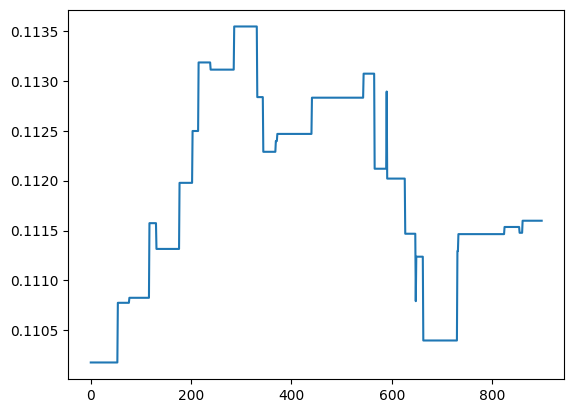

In [ ]:
plt.plot(density_all[100:])

In [ ]:
#plot_figure(coords)
write_xyz(coords,n_atoms,"test.xyz")

In [ ]:
avg_energy = np.mean(np.array(final_energy),axis=1)
std_energy = np.std(np.array(final_energy),axis=1)
print(avg_energy,std_energy)

[-246.42098393 -257.06227323 -208.08263795] [0. 0. 0.]


<ErrorbarContainer object of 3 artists>

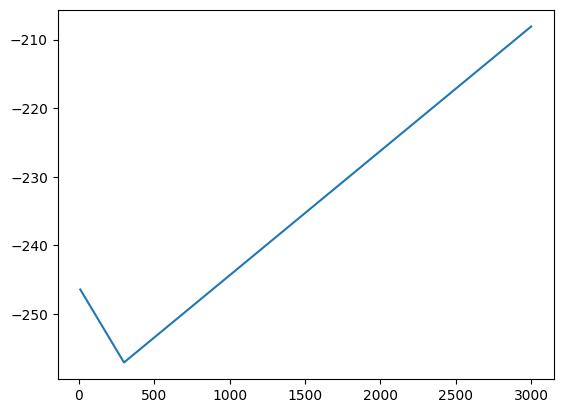

In [ ]:
plt.errorbar(T_all,avg_energy,yerr=std_energy)